In [169]:
from queue import Queue
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

In [54]:
class point:

    def __init__(self, x, y, data):
        #point data
        self.x = x
        self.y = y
        self.data = data

    def __repr__(self):
        return f'{{"x": {self.x}, "y": {self.y}}}'

In [55]:
class square:

    def __init__(self, x, y, l):
        # square cell initializing
        self.x = x
        self.y = y
        self.l = l
        self.points = []

    def __repr__(self):
        return f'({self.x}, {self.y}, {self.l})'

    def contains(self, point):
        # checks if point falls within a cell
        xcheck = self.x - (self.l / 2) <= point.x and self.x + (self.l / 2) >= point.x
        ycheck = self.y - (self.l / 2) <= point.y and self.y + (self.l / 2) >= point.y
        return xcheck and ycheck

In [110]:
class quadtree:

    def __init__(self, square, capacity, divided=False):
        #initialize quadtree object
        self.square = square
        self.capacity = capacity
        self.divided = divided
        self.topleft = None
        self.topright = None
        self.botleft = None
        self.botright = None

    def subdivide(self):
        #divide up the current cell
        x, y, l = self.square.x, self.square.y, self.square.l

        topleft = square(x-l/4, y+l/4, l/2)
        self.topleft = quadtree(topleft, 1)

        topright = square(x+l/4, y+l/4, l/2)
        self.topright = quadtree(topright, 1)

        botleft = square(x-l/4, y-l/4, l/2)
        self.botleft = quadtree(botleft, 1)

        botright = square(x+l/4, y-l/4, l/2)
        self.botright = quadtree(botright, 1)

        self.divided = True

        for point in self.square.points:
            result = self.topleft.insert(point)
            if not result:
                result = result or self.topright.insert(point)
            if not result:
                result = result or self.botleft.insert(point)
            if not result:
                result = result or self.botright.insert(point)

        self.square.points = []

    def insert(self, point):
        #insert a point into the quadtree
        if not self.square.contains(point):
            return False
        elif self.divided:
            result = self.topleft.insert(point)
            if not result:
                result = result or self.topright.insert(point)
            if not result:
                result = result or self.botleft.insert(point)
            if not result:
                result = result or self.botright.insert(point)
            return True
        elif len(self.square.points) < self.capacity:
            self.square.points.append(point)
            return True
        else:
            self.subdivide()
            result = self.topleft.insert(point)
            if not result:
                result = result or self.topright.insert(point)
            if not result:
                result = result or self.botleft.insert(point)
            if not result:
                result = result or self.botright.insert(point)
            return True

    def killemptychildren(self):
        #get rid of any cells that do not have points inisde
        if not self.divided and len(self.square.points) != 0:
            return

        if not self.topleft.divided and len(self.topleft.square.points) == 0:
            self.topleft = None
        else:
            self.topleft.killemptychildren()
        
        if not self.topright.divided and len(self.topright.square.points) == 0:
            self.topright = None
        else:
            self.topright.killemptychildren()

        if not self.botleft.divided and len(self.botleft.square.points) == 0:
            self.botleft = None
        else:
            self.botleft.killemptychildren()

        if not self.botright.divided and len(self.botright.square.points) == 0:
            self.botright = None
        else:
            self.botright.killemptychildren()

        

    def printsub(self):
        if self.divided is False and len(self.square.points) > 0:
            print(self.square)
            print(self.square.points)
        else:
            if self.topleft is not None:
                self.topleft.printsub()
            if self.topright is not None:
                self.topright.printsub()
            if self.botleft is not None:
                self.botleft.printsub()
            if self.botright is not None:
                self.botright.printsub()

    def getlistofpoints(self, lst):
        #gets list of points from a tree
        #input list in form of [[xcoords], [ycoords], [distribution]
        #colors are hard coded to work with 2 distributinos
        if self.divided is False and len(self.square.points) > 0:
            lst[0].append(self.square.points[0].x)
            lst[1].append(self.square.points[0].y)
            if min(self.square.points[0].data) > 0:
                lst[2].append(2)
            elif self.square.points[0].data[0] > 0:
                lst[2].append(0)
            elif self.square.points[0].data[1] > 0:
                lst[2].append(1)
            else:
                lst[2].append(1000)

            return lst
        if self.topleft is not None:
            lst = self.topleft.getlistofpoints(lst)
        if self.topright is not None:
            lst = self.topright.getlistofpoints(lst)
        if self.botleft is not None:
            lst = self.botleft.getlistofpoints(lst)
        if self.botright is not None:
            lst = self.botright.getlistofpoints(lst)
        
        return lst
    
    def getcellboundaries(self, lst):
        #returns info wiht correct format to print the line segments of the cells
        #format is list of lists [[[x1, x2],[x3,x4]],[[y1, y2],[y3,y4]]]
        
        
        line1x = [self.square.x - self.square.l / 2, self.square.x - self.square.l / 2]
        line1y = [self.square.y - self.square.l / 2, self.square.y + self.square.l / 2]
        lst[0].append(line1x)
        lst[1].append(line1y)

        line2x = [self.square.x - self.square.l / 2, self.square.x + self.square.l / 2]
        line2y = [self.square.y + self.square.l / 2, self.square.y + self.square.l / 2]
        lst[0].append(line2x)
        lst[1].append(line2y)

        line3x = [self.square.x + self.square.l / 2, self.square.x + self.square.l / 2]
        line3y = [self.square.y + self.square.l / 2, self.square.y - self.square.l / 2]
        lst[0].append(line3x)
        lst[1].append(line3y)

        line4x = [self.square.x - self.square.l / 2, self.square.x + self.square.l / 2]
        line4y = [self.square.y - self.square.l / 2, self.square.y - self.square.l / 2]
        lst[0].append(line4x)
        lst[1].append(line4y)

            
        
        if self.topleft is not None:
            lst = self.topleft.getcellboundaries(lst)
        if self.topright is not None:
            lst = self.topright.getcellboundaries(lst)
        if self.botleft is not None:
            lst = self.botleft.getcellboundaries(lst)
        if self.botright is not None:
            lst = self.botright.getcellboundaries(lst)

        return lst
    
    def plottree(self):
        #plots a quadtree, colors are hard coded for 2 distributions
        lstofpts = self.getlistofpoints([[],[],[]])

        qtreeboundaries = self.getcellboundaries([[],[]])

        for i in range(len(qtreeboundaries[0])):
            print("test")
            plt.plot(qtreeboundaries[0][i], qtreeboundaries[1][i], color="black")

        upperx = (self.square.x + self.square.l / 2) + .2 * abs(self.square.x + self.square.l / 2)
        uppery = (self.square.y + self.square.l / 2) + .2 * abs(self.square.y + self.square.l / 2)

        lowerx = (self.square.x - self.square.l / 2) - .2 * abs(self.square.x - self.square.l / 2)
        lowery = (self.square.y - self.square.l / 2) - .2 * abs(self.square.y - self.square.l / 2)
        dist1 = [[],[]]
        dist2 = [[],[]]
        bothdist = [[],[]]
        print(lstofpts)
        for i in range(len(lstofpts[0])):
            if lstofpts[2][i] == 0:
                dist1[0].append(lstofpts[0][i])
                dist1[1].append(lstofpts[1][i])
            elif lstofpts[2][i] == 1:
                dist2[0].append(lstofpts[0][i])
                dist2[1].append(lstofpts[1][i])
            else:
                bothdist[0].append(lstofpts[0][i])
                bothdist[1].append(lstofpts[1][i])
        plt.plot(dist1[0], dist1[1], 'ro', color="red")
        plt.plot(dist2[0], dist2[1], 'ro', color="blue")
        plt.plot(bothdist[0], bothdist[1], 'ro', color="purple")
        plt.axis((lowerx, upperx, lowery, uppery))
        plt.show()

In [57]:
def getboundingbox(lstofpts):
    minx = float('inf')
    maxx = -float('inf')
    miny = float('inf')
    maxy = -float('inf')

    for pt in lstofpts:
        if pt.x < minx:
            minx = pt.x
        if pt.x > maxx:
            maxx = pt.x
        if pt.y < miny:
            miny = pt.y
        if pt.y > maxy:
            maxy = pt.y


    centerx = (minx + maxx)/2
    centery = (miny + maxy)/2
    length = max(maxx-minx, maxy-miny)
    
    return centerx, centery, length

In [58]:
def getrandshift(lstofpts):
    #constructs the initial square for a random shift quadtree
    initx, inity, initlength = getboundingbox(lstofpts)
    minx = initx - initlength/2
    maxx = initx + initlength/2
    miny = inity - initlength/2
    maxy = inity + initlength/2

    shiftx = np.random.uniform(minx, maxx)
    shifty = np.random.uniform(miny, maxy)

    newlength = initlength*2
    
    return shiftx, shifty, newlength

In [59]:
def is_leaf(qtree):
    if qtree.divided == False:
        return True
    else:
        return False


In [151]:
def old_simple_barycenter(qtree, cost_func):
    global cost
    global barycenter

    if qtree == None:
        return []
    
    center = point(qtree.square.x, qtree.square.y, [])

    if is_leaf(qtree):
        p = qtree.square.points[0]
        k = len(p.data)     # number of distributions
        min_mass = min(p.data)
        if min_mass > 0:
            barycenter[(p.x, p.y)] = min_mass
            for i in range(k):
                p.data[i] -= min_mass
        if max(p.data) > 0.00000000000001:
            for m in p.data:
                cost += m * cost_func(p.x , qtree.square.x, p.y, qtree.square.y)
            return qtree.square.points
        else: 
            return []
    
    qtree.square.points = (old_simple_barycenter(qtree.topleft, cost_func) + old_simple_barycenter(qtree.topright, cost_func)
                         + old_simple_barycenter(qtree.botleft, cost_func) + old_simple_barycenter(qtree.botright, cost_func))
    if qtree.square.points == []:
        return []
    
    k = len(qtree.square.points[0].data)   # number of distributions
    mass = [0 for i in range(k)]
    pt_queue = Queue()
    for p in qtree.square.points:
        for i in range(k):
            mass[i] += p.data[i]
            cost += p.data[i] * cost_func(qtree.square.x , qtree.square.x + .25*qtree.square.l, qtree.square.y, qtree.square.y + .25*qtree.square.l)
        pt_queue.put(p)
    
    min_mass = min(mass)
    if min_mass > 0.00000000000001:
        barycenter[(center.x, center.y)] = min_mass
        mass_needed = [min_mass for i in range(k)]     # mass still to be paired for each distribution
        while max(mass_needed) > 0.00000000000001:
            p = pt_queue.get()
            for i in range(k):
                m = min(p.data[i], mass_needed[i])
                # cost += cost_func(center, p) * m
                p.data[i] -= m
                mass_needed[i] -= m
        
    return [p for p in qtree.square.points if max(p.data) > 0.00000000000001]

def simple_barycenter(qtree, cost_func, k):
    global cost
    global barycenter

    if qtree == None:
        return [0 for i in range(k)]
    
    center = point(qtree.square.x, qtree.square.y, [])

    if is_leaf(qtree):
        p = qtree.square.points[0]
        k = len(p.data)     # number of distributions
        min_mass = min(p.data)
        if min_mass > 0:
            barycenter[(p.x, p.y)] = min_mass
            for i in range(k):
                p.data[i] -= min_mass
        if max(p.data) > 0.00000000000001:
            for i in range(k):
                cost += p.data[i] * cost_func(p.x , qtree.square.x, p.y, qtree.square.y)
            return p.data
        else: 
            return [0 for i in range(k)]
    
    childmass = [simple_barycenter(qtree.topleft, cost_func, k) , simple_barycenter(qtree.topright, cost_func, k) , simple_barycenter(qtree.botleft, cost_func, k) , simple_barycenter(qtree.botright, cost_func, k)]
    if childmass == []:
        return []
        
    mass = [0 for i in range(k)]
    for lst in childmass:
        for i in range(len(lst)):
            mass[i] += lst[i]
            cost += lst[i] * cost_func(qtree.square.x , qtree.square.x + .25*qtree.square.l, qtree.square.y, qtree.square.y + .25*qtree.square.l)
    
    min_mass = min(mass)
    if min_mass > 0.00000000000001:
        barycenter[(center.x, center.y)] = min_mass
        for i in range(k):
            mass[i] -= min_mass
    
    return mass

In [115]:
def euclid_dist(a, b):
    return math.sqrt((b.x-a.x)**2 + (b.y-a.y)**2)

def euclidean_dist(x1, x2, y1, y2):
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

In [62]:
def normalize_image(im):
    s = np.sum(im)
    normalized_im = im/s
    return normalized_im

In [156]:
def images_to_points(images):
    points = []
    m = 0
    n = 0
    for im in images:
        if im.shape[0] > m:
            m = im.shape[0]
        if im.shape[1] > n:
            n = im.shape[1]

    for i in range(len(images)):
        row_diff = m - images[i].shape[0]
        col_diff = n - images[i].shape[1]
        images[i] = np.pad(images[i], ((math.floor(row_diff/2), math.ceil(row_diff/2)), (math.floor(col_diff/2), math.ceil(col_diff/2))),
                    'constant', constant_values=0)

    for i in range(m):
        for j in range(n):
            p = point(i, j, [im[i][j] for im in images])
            points.append(p)
            
    return points, (m, n)

In [137]:
cost = 0
barycenter = {}

sq = (0, 0, 3)
sq = square(0, 0, 3)
qtree = quadtree(sq, 1)
qtree.insert(point(0, 1.5, [2, 0, 0]))
qtree.insert(point(0, 0.5, [0, 2, 0]))
qtree.insert(point(1, -1.5, [0, 0, 1]))
qtree.killemptychildren()

print(simple_barycenter(qtree, euclidean_dist, 3))
print(cost)
print(barycenter)

[1, 1, 0]
10.066420204322759
{(0, 0): 1}


In [138]:
#test old barycenter
cost = 0
barycenter = {}

sq = (0, 0, 3)
sq = square(0, 0, 3)
qtree = quadtree(sq, 1)
qtree.insert(point(0, 1.5, [2, 0, 0]))
qtree.insert(point(0, 0.5, [0, 2, 0]))
qtree.insert(point(1, -1.5, [0, 0, 1]))
qtree.killemptychildren()

print(old_simple_barycenter(qtree, euclidean_dist))
print(cost)
print(barycenter)

[{"x": 0, "y": 1.5}, {"x": 0, "y": 0.5}]
10.066420204322759
{(0, 0): 1}


In [143]:
def plotbarycenter(barycenterdict, point_size, image_size):
    coords = barycenterdict.items()
    x = [pt[0][0] for pt in coords]
    y = [pt[0][1] for pt in coords]
    t = [pt[1] for pt in coords]
    # t = np.linspace(0, 1, len(x))
    fig, ax = plt.subplots()
    sc = ax.scatter(y, x, c=t, marker='.', s=point_size)
    fig.colorbar(sc, label="mass")
    plt.xlim(0, image_size[1])
    plt.ylim(0, image_size[0])
    plt.gca().invert_yaxis()
    plt.show()

[0, 0, 0]
0.0


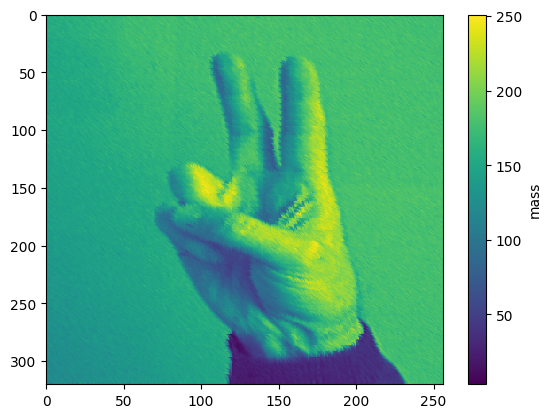

In [145]:
#test on identical images

from PIL import Image

hand0 = np.array(Image.open("testing images/hand0.png")) #load image and get pixel values
identical_image_points, center = images_to_points([hand0, hand0, hand0])

cost = 0
barycenter = {}
sq1_x, sq1_y, sq1_l = getboundingbox(identical_image_points)
sq1 = square(sq1_x, sq1_y, sq1_l)
qtree1 = quadtree(sq1, 1)
for p in identical_image_points:
    qtree1.insert(p)
qtree1.killemptychildren()
print(simple_barycenter(qtree1, euclidean_dist, 3))
print(cost)
plotbarycenter(barycenter, 100, center)

[]
0


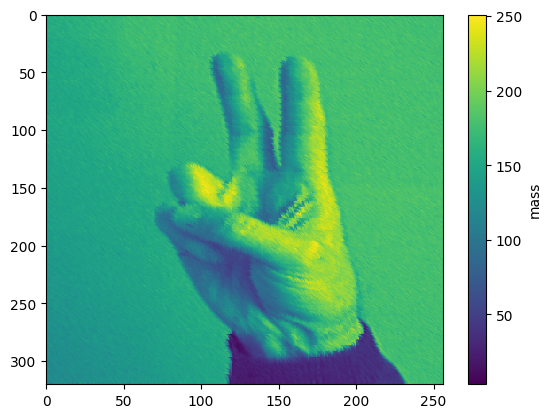

In [146]:
#test old barycenter on identical images

from PIL import Image

hand0 = np.array(Image.open("testing images/hand0.png")) #load image and get pixel values
identical_image_points, center = images_to_points([hand0, hand0, hand0])

cost = 0
barycenter = {}
sq1_x, sq1_y, sq1_l = getboundingbox(identical_image_points)
sq1 = square(sq1_x, sq1_y, sq1_l)
qtree1 = quadtree(sq1, 1)
for p in identical_image_points:
    qtree1.insert(p)
qtree1.killemptychildren()
print(old_simple_barycenter(qtree1, euclidean_dist))
print(cost)
plotbarycenter(barycenter, 100, center)

In [152]:
#test on very similar images

hand1 = np.array(Image.open("testing images/hand1.png")) 
normalized_hand0 = normalize_image(hand0)
normalized_hand1 = normalize_image(hand1)
similar_image_points = images_to_points([normalized_hand0, normalized_hand1])

cost = 0
barycenter = {}
sq2_x, sq2_y, sq2_l = getboundingbox(similar_image_points)
sq2 = square(sq2_x, sq2_y, sq2_l)
qtree2 = quadtree(sq2, 1)
for p in similar_image_points:
    qtree2.insert(p)
qtree2.killemptychildren()
print(simple_barycenter(qtree2, euclid_dist))
print(cost)
plotbarycenter(barycenter)

AttributeError: 'list' object has no attribute 'x'

[0.0, 2.7755575615628914e-17, 2.7755575615628914e-17]
160.14163854430686


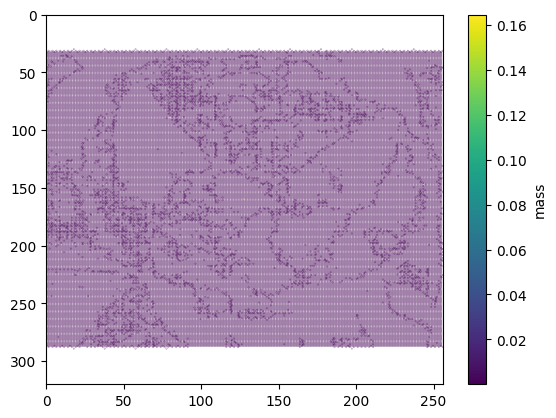

In [159]:
#test on a set of very different images
hand1 = np.array(Image.open("testing images/hand1.png")) 
normalized_hand0 = normalize_image(hand0)
normalized_hand1 = normalize_image(hand1)
tree = np.array(Image.open("testing images/tree.png").convert('L'))
normalized_tree = normalize_image(tree)
dog = np.array(Image.open("testing images/dog.png")) 
normalized_dog = normalize_image(dog)
similar_image_points, center = images_to_points([normalized_hand0, normalized_tree, normalized_dog])

cost = 0
barycenter = {}
sq2_x, sq2_y, sq2_l = getboundingbox(similar_image_points)
sq2 = square(sq2_x, sq2_y, sq2_l)
qtree2 = quadtree(sq2, 1)
for p in similar_image_points:
    qtree2.insert(p)
qtree2.killemptychildren()
print(simple_barycenter(qtree2, euclidean_dist, 3))
print(cost)
plotbarycenter(barycenter, .1, center)


[]
160.14163854431706


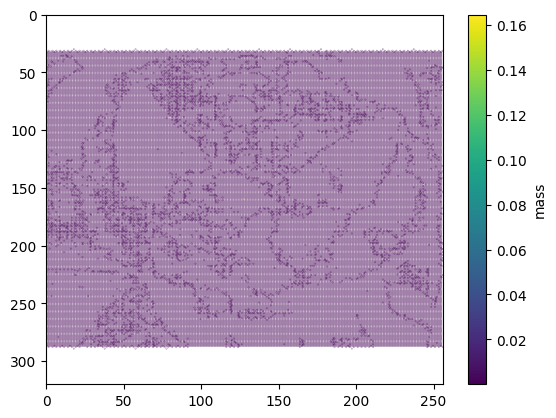

In [160]:
#test old barycenter on a set of very different images
hand1 = np.array(Image.open("testing images/hand1.png")) 
normalized_hand0 = normalize_image(hand0)
normalized_hand1 = normalize_image(hand1)
tree = np.array(Image.open("testing images/tree.png").convert('L'))
normalized_tree = normalize_image(tree)
dog = np.array(Image.open("testing images/dog.png")) 
normalized_dog = normalize_image(dog)
similar_image_points, center = images_to_points([normalized_hand0, normalized_tree, normalized_dog])

cost = 0
barycenter = {}
sq2_x, sq2_y, sq2_l = getboundingbox(similar_image_points)
sq2 = square(sq2_x, sq2_y, sq2_l)
qtree2 = quadtree(sq2, 1)
for p in similar_image_points:
    qtree2.insert(p)
qtree2.killemptychildren()
print(old_simple_barycenter(qtree2, euclidean_dist))
print(cost)
plotbarycenter(barycenter, .1, center)

[]
247.43434618957548


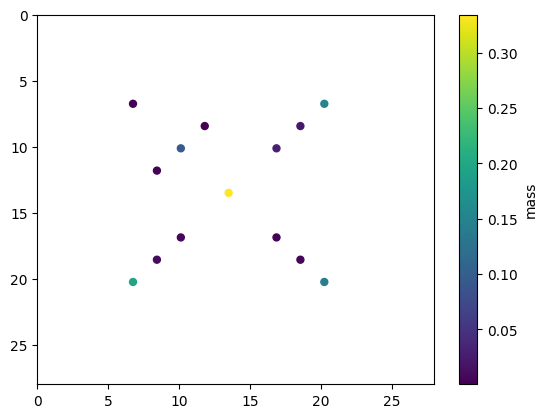

{(8.4375, 18.5625): 0.021837096159451157, (10.125, 16.875): 0.030199762347824136, (6.75, 20.25): 0.15149561180978935, (18.5625, 18.5625): 0.003572231520571557, (16.875, 16.875): 0.0028727736004596437, (20.25, 20.25): 0.1426560096585385, (8.4375, 11.8125): 0.0004344048653344917, (11.8125, 8.4375): 0.0024739267523647833, (10.125, 10.125): 0.09460666409781059, (6.75, 6.75): 0.0020097836463367153, (18.5625, 8.4375): 0.010538700310403524, (16.875, 10.125): 0.0056738104008218415, (20.25, 6.75): 0.1971566243933535, (13.5, 13.5): 0.3344726004369398}


In [173]:
#test on mnist zeros

import glob
zero_images = []
for filename in glob.glob('testing images/mnist_zeros/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    zero_images.append(normalized_im)
zero_image_points, zero_image_size = images_to_points(zero_images[:50])

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq2_l = getboundingbox(zero_image_points)
mnist_sq = square(mnist_sq_x, mnist_sq_y, mnist_sq2_l)
mnist_qtree0 = quadtree(mnist_sq, 1)
for p in zero_image_points:
    mnist_qtree0.insert(p)
mnist_qtree0.killemptychildren()
print(simple_barycenter(mnist_qtree0, euclid_dist))
print(cost)
plotbarycenter(barycenter, 100, zero_image_size)
print(barycenter)

[]
22.97660681896218


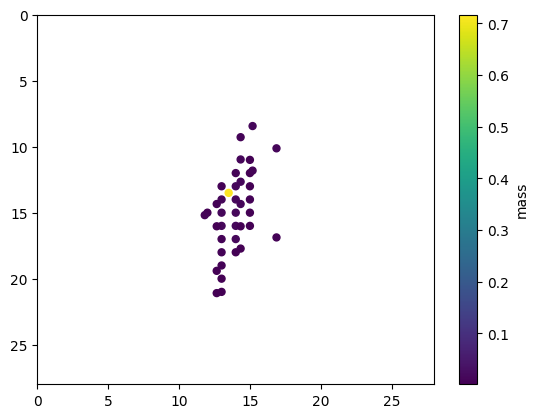

{(9.28125, 14.34375): 0.00795079507950795, (8.4375, 15.1875): 0.014751268072159578, (11, 15): 0.004172560113154172, (10.96875, 14.34375): 0.010603917534610605, (12, 15): 0.004172560113154172, (13, 15): 0.004172560113154172, (12, 14): 0.007575757575757576, (13, 14): 0.01452020202020202, (12.65625, 14.34375): 0.013901211549726403, (11.8125, 15.1875): 0.007359307359307359, (10.125, 16.875): 0.010427935600523847, (14, 15): 0.006718528995756719, (15, 15): 0.003101830836737782, (14, 14): 0.014634986225895317, (15, 14): 0.01452020202020202, (14.34375, 14.34375): 0.011712907058342648, (16, 15): 0.0017400514449992435, (16, 14): 0.01452020202020202, (16.03125, 14.34375): 0.0020481139126168647, (17, 14): 0.013315176274776819, (18, 14): 0.0033003300330033004, (17.71875, 14.34375): 0.001536308873738032, (16.875, 16.875): 0.0049227800673848614, (13, 13): 0.004800480048004801, (14, 13): 0.013501350135013501, (15, 13): 0.014462809917355372, (15, 12): 0.002292390741699327, (14.34375, 12.65625): 0.00627

In [163]:
#test with mnist ones

one_images = []
for filename in glob.glob('testing images/mnist_ones/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    one_images.append(normalized_im)
one_image_points, one_image_size = images_to_points(one_images[:5])

cost = 0
barycenter = {}
mnist_sq = square(mnist_sq_x, mnist_sq_y, mnist_sq2_l)
mnist_qtree1 = quadtree(mnist_sq, 1)
for p in one_image_points:
    mnist_qtree1.insert(p)
mnist_qtree1.killemptychildren()
print(simple_barycenter(mnist_qtree1, euclid_dist))
print(cost)
plotbarycenter(barycenter, 100, one_image_size)
print(barycenter)
print(one_images[0][10:, 10:])

In [171]:
n_trials = 200

215.72918749583732


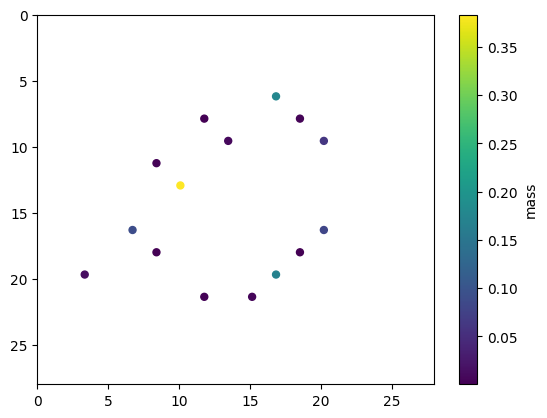

In [172]:
#test on zeros with random shift

zero_image_points, zero_image_size = images_to_points(zero_images[:50])
min_cost = 100000000
best_barycenter = {}
zero_costs = []

for i in range(n_trials):
    cost = 0
    barycenter = {}
    zero_image_points_copy = copy.deepcopy(zero_image_points)
    rand_x, rand_y, rand_l = getrandshift(zero_image_points_copy)
    rand_sq = square(rand_x, rand_y, rand_l)
    rqtree = quadtree(rand_sq, 1)
    for p in zero_image_points_copy:
        rqtree.insert(p)
    rqtree.killemptychildren()
    simple_barycenter(rqtree, euclid_dist)
    zero_costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_barycenter = barycenter.copy()

print(min_cost)
plotbarycenter(best_barycenter, 100, zero_image_size)

In [174]:
import statistics

print("average: %f" % statistics.mean(zero_costs))
print("SD: %f" % statistics.stdev(zero_costs))
print("max: %f" % max(zero_costs))

average: 306.950217
SD: 52.673459
max: 449.536673


300.28480416840796


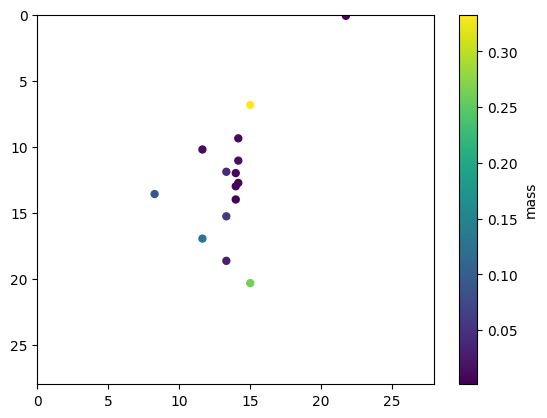

In [179]:
#test on ones with random shift

one_image_points, one_image_size = images_to_points(one_images[:100])
min_cost = 100000000
best_one_barycenter = {}
one_costs = []

for i in range(n_trials):
    cost = 0
    barycenter = {}
    one_image_points_copy = copy.deepcopy(one_image_points)
    rand_x, rand_y, rand_l = getrandshift(one_image_points_copy)
    rand_sq = square(rand_x, rand_y, rand_l)
    rqtree = quadtree(rand_sq, 1)
    for p in one_image_points_copy:
        rqtree.insert(p)
    rqtree.killemptychildren()
    simple_barycenter(rqtree, euclid_dist)
    one_costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_one_barycenter = barycenter.copy()

print(min_cost)
plotbarycenter(best_one_barycenter, 100, one_image_size)

In [180]:
print("average: %f" % statistics.mean(one_costs))
print("SD: %f" % statistics.stdev(one_costs))
print("max: %f" % max(one_costs))

average: 505.641410
SD: 168.833360
max: 1322.809806


In [ ]:
#test effect of shift
cost = 0
barycenter = {}
trials = 50

hand1 = np.array(Image.open("testing images/hand1.png")) 
normalized_hand0 = normalize_image(hand0)
tree = np.array(Image.open("testing images/tree.png").convert('L'))
normalized_tree = normalize_image(tree)
dog = np.array(Image.open("testing images/dog.png")) 
normalized_dog = normalize_image(dog)
similar_image_points, image_size = images_to_points([normalized_hand0, normalized_tree, normalized_dog])

shiftxlist = []
shiftylist = []
costlist = []

for i in range(trials):
    cost = 0
    barycenter = {}
    testx, testy, testl = getrandshift(similar_image_points)
    testsq = square(testx, testy, testl)
    testqtree = quadtree(testsq, 1)
    for pt in copy.deepcopy(similar_image_points):
        testqtree.insert(pt)
    testqtree.killemptychildren()
    simple_barycenter(testqtree, euclid_dist)
    
    shiftxlist.append(testx)
    shiftylist.append(testy)
    costlist.append(cost)

print(shiftxlist)
print(shiftylist)
print(costlist)
fig, ax = plt.subplots()
sc = ax.scatter(shiftxlist, shiftylist, c=costlist, marker='.', s=100)
fig.colorbar(sc, label="mass")
plt.xlim(0, image_size[1])
plt.ylim(0, image_size[0])
plt.gca().invert_yaxis()
plt.show()